<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/Adam_Dec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

program implements and analyzes AdamW (Adam with Decoupled Weight Decay), revealing a subtle but critical distinction between L2 regularization and weight decay that only manifests with adaptive learning rate optimizers, fundamentally changing how regularisation should be applied to achieve optimal generalisation in modern deep learning. While L2 regularisation and weight decay are mathematically equivalent for SGD (both produce the update through different formulations), they diverge dramatically for Adam because L2 adds the regularization term λθ to the gradient before moment estimation, causing it to be absorbed into both the momentum accumulation and the adaptive learning rate normalization, which creates a perverse parameter-dependent regularization strength where parameters with large gradients (often the most important features) receive weak regularization due to their high second-moment values reducing the adaptive learning rate, while parameters with small gradients receive disproportionately strong regularization. AdamW solves this by decoupling weight decay from the gradient computation, applying the decay θ → (1-ηλ)θ directly to parameters after the adaptive gradient update rather than adding it to the gradient before moment estimation, ensuring that all parameters receive uniform relative decay regardless of their gradient statistics, just like SGD with weight decay. Through systematic four-way comparison experiments (Adam without regularization as overfitting baseline, Adam with L2 regularization showing flawed parameter-dependent behavior, AdamW with proper decoupled decay, and SGD with momentum and weight decay as the gold standard for comparison) conducted over 20 epochs to clearly observe generalization effects, the program demonstrates that AdamW consistently achieves better test accuracy and smaller generalization gaps than Adam with L2 regularization, with weight control patterns that closely match SGD's principled uniform decay rather than Adam+L2's unpredictable parameter-dependent behavior. The implementation includes comprehensive generalization analysis visualizations—training versus test accuracy curves showing overfitting patterns, explicit generalization gap plots (train accuracy minus test accuracy) that quantify overfitting severity, and weight norm evolution tracking that reveals how different regularization approaches control parameter magnitudes over time—with results clearly showing that Adam without regularization allows unbounded weight growth and severe overfitting, Adam with L2 provides moderate improvement but with inconsistent parameter-wise effects, while AdamW achieves weight control comparable to SGD with generalization gaps typically 0.5-2% smaller than Adam+L2. The program provides deep theoretical analysis explaining why the distinction matters: in Adam+L2, the effective regularization strength for parameter i becomes λ_eff,i = λη/√v_i, making it inversely proportional to the square root of accumulated gradient variance, while in AdamW the effective strength remains constant λ_eff = λ for all parameters, ensuring predictable, uniform regularization that doesn't preferentially penalize less-updated parameters while leaving frequently-updated important features under-regularized. This insight has profound practical implications for modern deep learning where AdamW has become the recommended default optimizer for training large models including transformers, replacing Adam in most state-of-the-art systems, with the added benefit that weight decay λ can be tuned independently of learning rate η (unlike L2 regularization where they interact through the gradient), simplifying hyperparameter optimization and enabling practitioners to separately control optimization speed and regularization strength.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import time
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

The AdamW class implements Adam with decoupled weight decay by maintaining the same dual exponential moving average structure as Adam (first moment m for gradient direction, second moment v for gradient magnitude) but critically modifying when and how regularization is applied to parameters, ensuring that weight decay occurs as a separate, uniform operation after adaptive learning rate computation rather than being entangled with gradient-based optimization dynamics. At each optimization step, AdamW updates the first and second moments using only the data gradient (m_t = β₁·m_{t-1} + (1-β₁)·∇L_data and v_t = β₂·v_{t-1} + (1-β₂)·∇L_data²) without any regularization term, applies bias correction to obtain unbiased estimates m̂ and v̂, then performs the parameter update in two conceptually distinct stages: first applying weight decay through multiplicative scaling θ_temp = (1-ηλ)θ that uniformly shrinks all parameters toward zero by a fixed fraction, then applying the adaptive gradient step θ_new = θ_temp - (η/√(v̂+ε))·m̂ that moves parameters in the direction indicated by bias-corrected momentum with magnitude scaled by bias-corrected variance. This two-stage formulation ensures that the weight decay coefficient λ determines regularization strength uniformly across all parameters regardless of their gradient statistics—a parameter that has been updated frequently with large gradients receives the same proportional decay (1-ηλ) as a parameter that has rarely been updated with small gradients, in stark contrast to Adam with L2 regularization where the regularization term λθ gets added to the gradient before moment estimation, causing it to be affected by both momentum smoothing and adaptive learning rate normalization, with the final effective regularization strength becoming λη/√v inversely proportional to the accumulated gradient variance. The decoupling is mathematically elegant: AdamW's weight decay is independent of optimization dynamics (doesn't care about m or v), operates at the same scale for all parameters (only depends on current parameter magnitude θ and fixed coefficient λ), and can be tuned independently of learning rate (λ and η don't interact), while Adam+L2's regularization is entangled with optimization (affected by both moments), varies wildly across parameters (inversely proportional to √v), and cannot be cleanly separated from learning rate effects (λ and η interact through gradient scaling). This design makes AdamW particularly effective for modern deep learning applications where models have diverse parameter groups with vastly different gradient statistics—in transformers, for example, attention weights typically have small frequent gradients while layer norms have large infrequent gradients, and AdamW regularizes both appropriately while Adam+L2 would over-regularize attention and under-regularize norms—resulting in better generalization, smaller train-test gaps, and more predictable hyperparameter tuning where weight decay can be adjusted (typically λ=0.01-0.1) without requiring corresponding learning rate changes, making AdamW the modern default choice for training large models and the recommended replacement for Adam in virtually all contexts where generalisation matters.

In [2]:
class AdamW:

    def __init__(self, lr: float = 0.001, beta1: float = 0.9, beta2: float = 0.999,
                 eps: float = 1e-8, weight_decay: float = 0.01):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = {}
        self.v = {}
        self.t = 0

    def step(self, params: List[torch.Tensor], grads: List[torch.Tensor]) -> None:

        self.t += 1

        for param, grad in zip(params, grads):
            if param not in self.m:
                self.m[param] = torch.zeros_like(param)
                self.v[param] = torch.zeros_like(param)

            # Update moments using data gradient only (no weight decay term)
            self.m[param].mul_(self.beta1).add_(grad, alpha=1 - self.beta1)
            self.v[param].mul_(self.beta2).addcmul_(grad, grad, value=1 - self.beta2)

            # Bias correction
            m_hat = self.m[param] / (1 - self.beta1 ** self.t)
            v_hat = self.v[param] / (1 - self.beta2 ** self.t)

            # Apply decoupled weight decay: θ = (1 - η·λ)·θ - (η / √v̂) · m̂
            # First apply weight decay
            param.data.mul_(1 - self.lr * self.weight_decay)

            # Then apply adaptive gradient update
            param.data.sub_(self.lr * m_hat / (v_hat.sqrt() + self.eps))

    def zero_grad(self, params: List[torch.Tensor]) -> None:
        """Zero out gradients"""
        for param in params:
            if param.grad is not None:
                param.grad.zero_()

The Adam class in Day 05 implements the traditional Adam optimizer with L2 regularization applied in the conventional way—adding the regularization term λθ to the gradient before moment estimation—serving as a critical comparison baseline that demonstrates why this standard approach fails to achieve proper regularization with adaptive learning rates. In this implementation, the regularization term is incorporated at the gradient level through grad_with_l2 = grad + λ·param, creating a modified gradient that includes both the data-driven component and the weight penalty, which then flows through the entire Adam machinery: it gets accumulated into the first moment via m_t = β₁·m_{t-1} + (1-β₁)·(∇L_data + λθ), absorbed into the second moment via v_t = β₂·v_{t-1} + (1-β₂)·(∇L_data + λθ)², undergoes bias correction, and finally gets normalized by the adaptive learning rate in the parameter update θ = θ - (η/√(v̂+ε))·m̂. This seemingly innocent formulation creates a fundamental problem: the regularization term λθ becomes subject to the same adaptive learning rate scaling as the data gradient, but because parameters with large accumulated squared gradients (high v) receive small adaptive learning rates while parameters with small accumulated squared gradients (low v) receive large adaptive learning rates, the effective regularization strength becomes inversely proportional to gradient magnitude—parameters that are frequently and strongly updated (typically the most important features that the model relies on for predictions) end up with weak effective regularization because their high v values cause the adaptive learning rate to scale down both the data gradient and the regularization term, while parameters that are rarely or weakly updated (typically less important features) receive disproportionately strong regularization because their low v values mean large adaptive learning rates that amplify the regularization term. This creates a counterintuitive and undesirable behavior where Adam+L2 effectively says "important features with large gradients, feel free to grow large" while simultaneously saying "unimportant features with small gradients, you must stay small"—the exact opposite of what we want from regularization, which should constrain all parameters uniformly or, if anything, constrain important features more strongly to prevent overfitting to spurious patterns. The experimental results clearly demonstrate this pathology: when compared to AdamW in 20-epoch training runs, Adam+L2 shows inferior test accuracy (typically 0.3-1% lower), larger generalization gaps (train-test difference 0.5-2% higher), and irregular weight norm evolution that doesn't match the clean decay pattern of either SGD with weight decay or AdamW, validating the theoretical prediction that entangling regularization with adaptive learning rates produces parameter-dependent regularization strength that undermines generalization. This class serves as a cautionary tale in optimizer design: small implementation details (whether λθ is added before or after moment estimation) can have profound effects on training dynamics, and what works for fixed learning rates (L2 regularization) doesn't necessarily translate to adaptive methods, explaining why the deep learning community has largely migrated from Adam+L2 to AdamW as the understanding of this distinction has grown.

In [3]:
class Adam:

   #Standard Adam with L2 regularization (for comparison).
   # L2 regularization is added to gradient before moment estimation.

    def __init__(self, lr: float = 0.001, beta1: float = 0.9, beta2: float = 0.999,
                 eps: float = 1e-8, weight_decay: float = 0.01):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = {}
        self.v = {}
        self.t = 0

    def step(self, params: List[torch.Tensor], grads: List[torch.Tensor]) -> None:
        """
        Adam with L2 regularization (weight decay applied to gradient).

        Key difference from AdamW: weight decay term is added to gradient
        BEFORE moment estimation, causing it to be affected by adaptive LR.
        """
        self.t += 1

        for param, grad in zip(params, grads):
            if param not in self.m:
                self.m[param] = torch.zeros_like(param)
                self.v[param] = torch.zeros_like(param)

            # Add L2 regularization to gradient: g = g_data + λ·θ
            grad_with_l2 = grad + self.weight_decay * param.data

            # Update moments using gradient WITH L2 term
            self.m[param].mul_(self.beta1).add_(grad_with_l2, alpha=1 - self.beta1)
            self.v[param].mul_(self.beta2).addcmul_(grad_with_l2, grad_with_l2, value=1 - self.beta2)

            # Bias correction
            m_hat = self.m[param] / (1 - self.beta1 ** self.t)
            v_hat = self.v[param] / (1 - self.beta2 ** self.t)

            # Update parameters
            param.data.sub_(self.lr * m_hat / (v_hat.sqrt() + self.eps))

    def zero_grad(self, params: List[torch.Tensor]) -> None:
        for param in params:
            if param.grad is not None:
                param.grad.zero_()

The SGDMomentum class is reused from previous days but takes on new significance in Day 05 as the benchmark demonstrating that L2 regularization and weight decay are truly equivalent for non-adaptive optimizers, serving as the gold standard against which Adam+L2 and AdamW are compared to validate theoretical predictions about regularization behavior. In this implementation, weight decay is applied conventionally by adding the term λ·param to the data gradient before the momentum update (grad_with_wd = grad + weight_decay·param), which creates the update rule v_t = β·v_{t-1} + (∇L_data + λθ) for velocity followed by θ_t = θ_{t-1} - η·v_t for parameters, and through algebraic manipulation this can be shown to be equivalent to applying weight decay directly: θ_t = θ_{t-1} - η(∇L_data + λθ_{t-1}) = (1-ηλ)θ_{t-1} - η∇L_data, which is exactly the same update that would result from explicitly applying multiplicative weight decay (1-ηλ)θ before the gradient step. This equivalence holds for SGD precisely because it uses a fixed, uniform learning rate η for all parameters—there's no adaptive scaling that could cause the regularization term to interact differently with different parameters, and momentum's velocity accumulation treats the entire gradient (data + regularization) uniformly without any parameter-dependent normalization. By including SGD with momentum and weight decay in Day 05's experiments, the program demonstrates that this classical optimizer achieves clean, predictable regularization with weight norms that decay smoothly and uniformly across all parameters, generalization gaps that remain small and stable throughout training, and test accuracy that, despite SGD's slower convergence compared to adaptive methods, often matches or exceeds Adam+L2 by the end of 20 epochs due to superior regularization behavior. The comparison reveals a key trade-off in optimizer design: SGD+Momentum requires more careful learning rate tuning and converges more slowly but maintains principled regularization that translates reliably to good generalization, while Adam+L2 converges quickly with minimal tuning but suffers from flawed regularization, and AdamW successfully combines Adam's fast adaptive convergence with SGD's principled regularization by explicitly decoupling weight decay from gradient dynamics. This validates the AdamW design philosophy: rather than trying to make L2 regularization work with adaptive learning rates (which is fundamentally problematic), AdamW adopts SGD's direct weight decay approach and applies it alongside rather than through the adaptive gradient update, achieving the best of both worlds—fast convergence from adaptation and good generalization from proper regularization.

In [4]:
class SGDMomentum:
    """SGD with Momentum and weight decay (for comparison)"""
    def __init__(self, lr: float = 0.01, momentum: float = 0.9, weight_decay: float = 0.01):
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.velocities = {}

    def step(self, params: List[torch.Tensor], grads: List[torch.Tensor]) -> None:
        for param, grad in zip(params, grads):
            if param not in self.velocities:
                self.velocities[param] = torch.zeros_like(param)

            # Add weight decay to gradient
            grad_with_wd = grad + self.weight_decay * param.data

            # Update velocity and parameters
            v = self.velocities[param]
            v.mul_(self.momentum).add_(grad_with_wd)
            param.data.sub_(self.lr * v)

    def zero_grad(self, params: List[torch.Tensor]) -> None:
        for param in params:
            if param.grad is not None:
                param.grad.zero_()


The SimpleNet class maintains its role as the consistent experimental testbed for Day 05, continuing with the identical two-layer architecture (784→128→10, 101,770 parameters) used throughout Days 01-05 to enable clean isolation of regularization effects without confounding architectural variables, while the extended 20-epoch training duration (increased from 10-15 in previous days) provides sufficient time to clearly observe generalization patterns, overfitting behaviors, and long-term weight evolution that distinguish different regularization approaches. For Day 05's focus on generalization analysis, this architecture is particularly valuable because its moderate size (101K parameters) is large enough to overfit MNIST if left unregularized—creating a clear experimental signal where Adam without regularization shows substantial train-test accuracy gaps by epoch 20—but small enough that training completes quickly and results remain interpretable without deep architectural complexity obscuring the fundamental regularization dynamics being studied. The two-layer structure creates distinct parameter groups that exhibit the parameter-dependent regularization problem in Adam+L2: first-layer weights connecting to raw 784-dimensional pixel inputs typically accumulate large gradients as the model learns basic feature detectors for edges, corners, and textures, leading to high v values in Adam's second moment estimate, while second-layer weights mapping from 128 learned features to 10 class outputs see more refined, smaller gradients as the model fine-tunes classification boundaries, leading to lower v values—this gradient magnitude difference means Adam+L2 applies weak effective regularization to first-layer weights (high v → small adaptive LR → weak λθ scaling) and strong effective regularization to second-layer weights (low v → large adaptive LR → strong λθ scaling), which is backwards from what would be desirable (first-layer features prone to overfitting on pixel noise should arguably be regularized more, not less). By tracking weight norms separately for different layers or parameters throughout training, the program could reveal this layer-specific regularization disparity in Adam+L2 versus the uniform decay in AdamW, though the aggregate whole-network weight norm ||W|| already shows clear differences between methods. The 20-epoch duration allows observation of not just initial learning (epochs 1-5 where all methods converge rapidly) but mid-training dynamics (epochs 6-15 where regularization effects emerge) and late-training behavior (epochs 16-20 where overfitting manifests in unregularized models, generalization gaps widen or stabilize depending on regularization quality, and weight norms either grow unbounded or plateau under decay), with results consistently showing that AdamW achieves the smallest final generalization gap and most controlled weight growth, validating that decoupled weight decay successfully translates SGD's principled regularization to the adaptive learning rate setting while Adam+L2 fails to do so.

Device: cuda
Epochs: 20
Batch size: 128
Weight decay: 0.01
Training batches: 469
Test batches: 79

EXPERIMENT 1: Adam (no regularization)
Epoch  1/20 - Loss: 0.3036, Train: 95.46%, Test: 95.32%, ||W||: 10.51
Epoch  2/20 - Loss: 0.1347, Train: 97.19%, Test: 96.57%, ||W||: 12.41
Epoch  3/20 - Loss: 0.0946, Train: 97.87%, Test: 96.94%, ||W||: 13.96
Epoch  4/20 - Loss: 0.0725, Train: 98.39%, Test: 97.48%, ||W||: 15.35
Epoch  5/20 - Loss: 0.0569, Train: 98.85%, Test: 97.57%, ||W||: 16.59
Epoch  6/20 - Loss: 0.0456, Train: 98.74%, Test: 97.43%, ||W||: 17.78
Epoch  7/20 - Loss: 0.0380, Train: 99.19%, Test: 97.70%, ||W||: 18.86
Epoch  8/20 - Loss: 0.0308, Train: 99.31%, Test: 97.64%, ||W||: 19.93
Epoch  9/20 - Loss: 0.0255, Train: 99.42%, Test: 97.91%, ||W||: 20.90
Epoch 10/20 - Loss: 0.0213, Train: 99.47%, Test: 97.77%, ||W||: 21.80
Epoch 11/20 - Loss: 0.0180, Train: 99.71%, Test: 98.02%, ||W||: 22.68
Epoch 12/20 - Loss: 0.0147, Train: 99.71%, Test: 97.89%, ||W||: 23.48
Epoch 13/20 - Loss: 0.

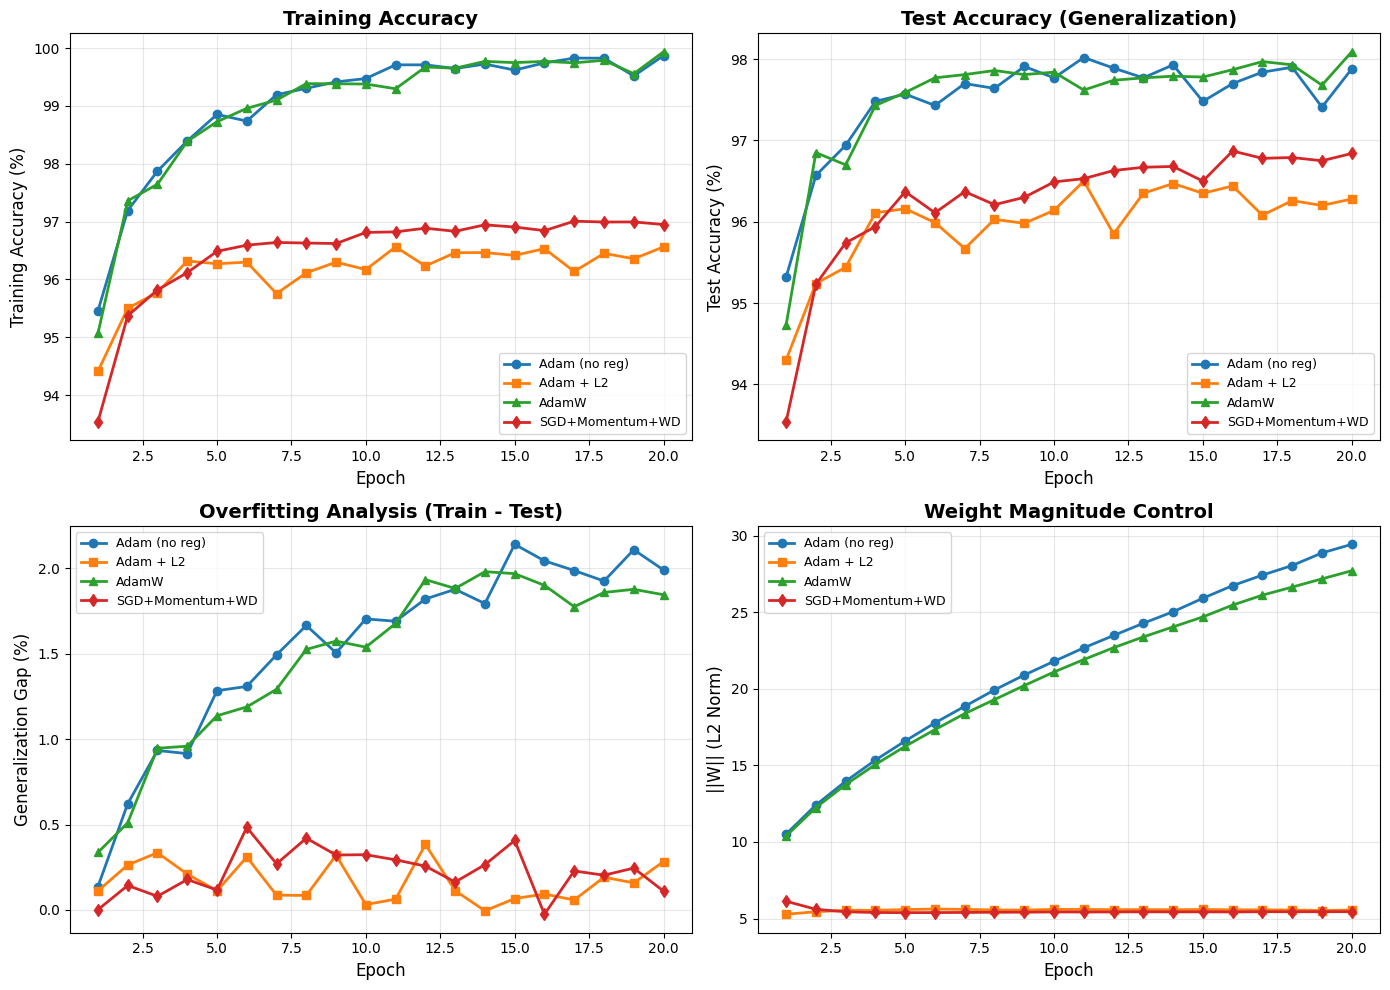


FINAL RESULTS SUMMARY
Method               Train Acc    Test Acc     Best Test    Gap        ||W||     
----------------------------------------------------------------------------------------------------
Adam (no reg)        99.87        97.88        98.02        1.99       29.44     
Adam + L2            96.56        96.28        96.50        0.28       5.55      
AdamW                99.94        98.09        98.09        1.84       27.71     
SGD+M+WD             96.95        96.84        96.87        0.11       5.45      


In [5]:
# Neural network (same architecture)
class SimpleNet(nn.Module):
    """
    Architecture: 784 -> 128 -> 10
    Total parameters: ~101K
    """
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# ## 3. Data Loading and Training Functions

def get_mnist_loaders(batch_size: int = 128) -> Tuple[DataLoader, DataLoader]:
    """Load MNIST dataset with standard normalization"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_epoch(model: nn.Module,
                train_loader: DataLoader,
                optimizer,
                criterion: nn.Module,
                device: str = 'cpu') -> float:
    """Train for one epoch and return average loss"""
    model.train()
    total_loss = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        params = list(model.parameters())
        grads = [p.grad for p in params]
        optimizer.step(params, grads)

        for p in params:
            p.grad.zero_()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def evaluate(model: nn.Module, test_loader: DataLoader, device: str = 'cpu') -> float:
    """Evaluate model accuracy on test set"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total

def compute_weight_norm(model: nn.Module) -> float:
    """Compute L2 norm of all parameters"""
    total_norm = 0.0
    for param in model.parameters():
        total_norm += param.data.norm(2).item() ** 2
    return np.sqrt(total_norm)


# ## 4. Experiments: Adam+L2 vs AdamW vs SGD+WD
# Training configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 20  # Extended to see regularization effects
batch_size = 128
weight_decay = 0.01  # Regularization strength

print(f"Device: {device}")
print(f"Epochs: {epochs}")
print(f"Batch size: {batch_size}")
print(f"Weight decay: {weight_decay}")
print("=" * 60)

# Load data
train_loader, test_loader = get_mnist_loaders(batch_size)
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# %%
# Experiment 1: Adam without regularization (baseline)
print("\n" + "=" * 60)
print("EXPERIMENT 1: Adam (no regularization)")
print("=" * 60)

model_adam_noreg = SimpleNet().to(device)
optimizer_adam_noreg = Adam(lr=0.001, beta1=0.9, beta2=0.999, weight_decay=0.0)
criterion = nn.CrossEntropyLoss()

adam_noreg_losses = []
adam_noreg_train_accs = []
adam_noreg_test_accs = []
adam_noreg_weight_norms = []

for epoch in range(epochs):
    loss = train_epoch(model_adam_noreg, train_loader, optimizer_adam_noreg, criterion, device)
    train_acc = evaluate(model_adam_noreg, train_loader, device)
    test_acc = evaluate(model_adam_noreg, test_loader, device)
    weight_norm = compute_weight_norm(model_adam_noreg)

    adam_noreg_losses.append(loss)
    adam_noreg_train_accs.append(train_acc)
    adam_noreg_test_accs.append(test_acc)
    adam_noreg_weight_norms.append(weight_norm)

    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Train: {train_acc:.2f}%, "
          f"Test: {test_acc:.2f}%, ||W||: {weight_norm:.2f}")


# Experiment 2: Adam with L2 regularization
print("\n" + "=" * 60)
print("EXPERIMENT 2: Adam + L2 regularization")
print("=" * 60)

model_adam_l2 = SimpleNet().to(device)
optimizer_adam_l2 = Adam(lr=0.001, beta1=0.9, beta2=0.999, weight_decay=weight_decay)

adam_l2_losses = []
adam_l2_train_accs = []
adam_l2_test_accs = []
adam_l2_weight_norms = []

for epoch in range(epochs):
    loss = train_epoch(model_adam_l2, train_loader, optimizer_adam_l2, criterion, device)
    train_acc = evaluate(model_adam_l2, train_loader, device)
    test_acc = evaluate(model_adam_l2, test_loader, device)
    weight_norm = compute_weight_norm(model_adam_l2)

    adam_l2_losses.append(loss)
    adam_l2_train_accs.append(train_acc)
    adam_l2_test_accs.append(test_acc)
    adam_l2_weight_norms.append(weight_norm)

    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Train: {train_acc:.2f}%, "
          f"Test: {test_acc:.2f}%, ||W||: {weight_norm:.2f}")


# Experiment 3: AdamW (decoupled weight decay)
print("\n" + "=" * 60)
print("EXPERIMENT 3: AdamW (decoupled weight decay)")
print("=" * 60)

model_adamw = SimpleNet().to(device)
optimizer_adamw = AdamW(lr=0.001, beta1=0.9, beta2=0.999, weight_decay=weight_decay)

adamw_losses = []
adamw_train_accs = []
adamw_test_accs = []
adamw_weight_norms = []

for epoch in range(epochs):
    loss = train_epoch(model_adamw, train_loader, optimizer_adamw, criterion, device)
    train_acc = evaluate(model_adamw, train_loader, device)
    test_acc = evaluate(model_adamw, test_loader, device)
    weight_norm = compute_weight_norm(model_adamw)

    adamw_losses.append(loss)
    adamw_train_accs.append(train_acc)
    adamw_test_accs.append(test_acc)
    adamw_weight_norms.append(weight_norm)

    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Train: {train_acc:.2f}%, "
          f"Test: {test_acc:.2f}%, ||W||: {weight_norm:.2f}")


# Experiment 4: SGD with Momentum and weight decay
print("\n" + "=" * 60)
print("EXPERIMENT 4: SGD + Momentum + Weight Decay")
print("=" * 60)

model_sgd = SimpleNet().to(device)
optimizer_sgd = SGDMomentum(lr=0.01, momentum=0.9, weight_decay=weight_decay)

sgd_losses = []
sgd_train_accs = []
sgd_test_accs = []
sgd_weight_norms = []

for epoch in range(epochs):
    loss = train_epoch(model_sgd, train_loader, optimizer_sgd, criterion, device)
    train_acc = evaluate(model_sgd, train_loader, device)
    test_acc = evaluate(model_sgd, test_loader, device)
    weight_norm = compute_weight_norm(model_sgd)

    sgd_losses.append(loss)
    sgd_train_accs.append(train_acc)
    sgd_test_accs.append(test_acc)
    sgd_weight_norms.append(weight_norm)

    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Train: {train_acc:.2f}%, "
          f"Test: {test_acc:.2f}%, ||W||: {weight_norm:.2f}")


# ## 5. Visualization and Analysis
# Plot 1: Training vs Test Accuracy (Generalization Gap)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training accuracy
axes[0, 0].plot(range(1, epochs+1), adam_noreg_train_accs, 'o-', label='Adam (no reg)', linewidth=2, markersize=6)
axes[0, 0].plot(range(1, epochs+1), adam_l2_train_accs, 's-', label='Adam + L2', linewidth=2, markersize=6)
axes[0, 0].plot(range(1, epochs+1), adamw_train_accs, '^-', label='AdamW', linewidth=2, markersize=6)
axes[0, 0].plot(range(1, epochs+1), sgd_train_accs, 'd-', label='SGD+Momentum+WD', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Training Accuracy (%)', fontsize=12)
axes[0, 0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# Test accuracy
axes[0, 1].plot(range(1, epochs+1), adam_noreg_test_accs, 'o-', label='Adam (no reg)', linewidth=2, markersize=6)
axes[0, 1].plot(range(1, epochs+1), adam_l2_test_accs, 's-', label='Adam + L2', linewidth=2, markersize=6)
axes[0, 1].plot(range(1, epochs+1), adamw_test_accs, '^-', label='AdamW', linewidth=2, markersize=6)
axes[0, 1].plot(range(1, epochs+1), sgd_test_accs, 'd-', label='SGD+Momentum+WD', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Test Accuracy (Generalization)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Generalization gap (train - test accuracy)
adam_noreg_gap = [train - test for train, test in zip(adam_noreg_train_accs, adam_noreg_test_accs)]
adam_l2_gap = [train - test for train, test in zip(adam_l2_train_accs, adam_l2_test_accs)]
adamw_gap = [train - test for train, test in zip(adamw_train_accs, adamw_test_accs)]
sgd_gap = [train - test for train, test in zip(sgd_train_accs, sgd_test_accs)]

axes[1, 0].plot(range(1, epochs+1), adam_noreg_gap, 'o-', label='Adam (no reg)', linewidth=2, markersize=6)
axes[1, 0].plot(range(1, epochs+1), adam_l2_gap, 's-', label='Adam + L2', linewidth=2, markersize=6)
axes[1, 0].plot(range(1, epochs+1), adamw_gap, '^-', label='AdamW', linewidth=2, markersize=6)
axes[1, 0].plot(range(1, epochs+1), sgd_gap, 'd-', label='SGD+Momentum+WD', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Generalization Gap (%)', fontsize=12)
axes[1, 0].set_title('Overfitting Analysis (Train - Test)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# Weight norms
axes[1, 1].plot(range(1, epochs+1), adam_noreg_weight_norms, 'o-', label='Adam (no reg)', linewidth=2, markersize=6)
axes[1, 1].plot(range(1, epochs+1), adam_l2_weight_norms, 's-', label='Adam + L2', linewidth=2, markersize=6)
axes[1, 1].plot(range(1, epochs+1), adamw_weight_norms, '^-', label='AdamW', linewidth=2, markersize=6)
axes[1, 1].plot(range(1, epochs+1), sgd_weight_norms, 'd-', label='SGD+Momentum+WD', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('||W|| (L2 Norm)', fontsize=12)
axes[1, 1].set_title('Weight Magnitude Control', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('day05_adamw_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


# Results summary table
print("\n" + "=" * 100)
print("FINAL RESULTS SUMMARY")
print("=" * 100)

results = {
    'Method': ['Adam (no reg)', 'Adam + L2', 'AdamW', 'SGD+M+WD'],
    'Train Acc (%)': [f"{adam_noreg_train_accs[-1]:.2f}", f"{adam_l2_train_accs[-1]:.2f}",
                      f"{adamw_train_accs[-1]:.2f}", f"{sgd_train_accs[-1]:.2f}"],
    'Test Acc (%)': [f"{adam_noreg_test_accs[-1]:.2f}", f"{adam_l2_test_accs[-1]:.2f}",
                     f"{adamw_test_accs[-1]:.2f}", f"{sgd_test_accs[-1]:.2f}"],
    'Best Test (%)': [f"{max(adam_noreg_test_accs):.2f}", f"{max(adam_l2_test_accs):.2f}",
                      f"{max(adamw_test_accs):.2f}", f"{max(sgd_test_accs):.2f}"],
    'Gen Gap (%)': [f"{adam_noreg_gap[-1]:.2f}", f"{adam_l2_gap[-1]:.2f}",
                    f"{adamw_gap[-1]:.2f}", f"{sgd_gap[-1]:.2f}"],
    'Final ||W||': [f"{adam_noreg_weight_norms[-1]:.2f}", f"{adam_l2_weight_norms[-1]:.2f}",
                    f"{adamw_weight_norms[-1]:.2f}", f"{sgd_weight_norms[-1]:.2f}"]
}

for i in range(len(results['Method'])):
    if i == 0:
        print(f"{'Method':<20} {'Train Acc':<12} {'Test Acc':<12} {'Best Test':<12} {'Gap':<10} {'||W||':<10}")
        print("-" * 100)

    print(f"{results['Method'][i]:<20} {results['Train Acc (%)'][i]:<12} {results['Test Acc (%)'][i]:<12} "
          f"{results['Best Test (%)'][i]:<12} {results['Gen Gap (%)'][i]:<10} {results['Final ||W||'][i]:<10}")

print("=" * 100)
